In [5]:
####################################################################################################
# CR.Aeronet.ipynb
# Karl Lapo July/2015
####################################################################################################
# Using aerosol data from the Fresno Aeronet site
####################################################################################################

# must insert this statement to render the plots within the notebook
# this is specific to the ipython notebook
%matplotlib inline

## FLAGS for processing
flag_getdata = 0              # Load and process raw data (1)? Or load pre-processed data (0)?

## Import statements
# netcdf/numpy/xray
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xray

# OS interaction
import sys, pickle, os

# import subplots function for plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap

# Solargeometry
import solargeo

## Directory listing
# dir_data = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data'
# dir_print = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

dir_data = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/data'
dir_print = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/Graphics'

# List of sub-directory names for each data set
dir_NLDAS = '/NLDAS'
dir_SYN = '/CERES_SYN'
dir_grobs = '/GroundObs'
dir_VIC = '/VIC_MTCLIM'
dir_AN = '/aeronet'

# Directory for basemap pickle files
# dir_bmap = '/Users/karllapo/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'
dir_bmap = '/Users/studentuser/gdrive/SnowHydrology/proj/CloudClimatology/data/basemap'

ImportError: No module named solargeo

In [2]:
##### Read aeronet csv, get total aerosol optical depth
def parse(str1, str2):
    date_str = str1+'_'+str2
    dt = datetime.strptime(date_str,"%d:%m:%Y_%H:%M:%S")
    return dt

iter_count = 0
os.chdir(dir_data+dir_AN)
fid = '020101_121231_Fresno.ONEILL_20'
with open(fid, 'r') as datafile:
    # Skip the header of arbitrary size and read the column names
    if iter_count == 0:
        line = datafile.readline()
        iter_count = iter_count+1
    while not line.startswith('Date(dd:mm:yyyy)'):
        line = datafile.readline()
    line = line.replace('\n','')
    col_names = line.split(',')
    col_names[-1] = 'wavelength-1'
    col_names.append('wavelength-2')
    col_names.append('wavelength-3')
    col_names.append('wavelength-4')
    col_names.append('wavelength-5')
    data = pd.read_csv(datafile, names=col_names, sep= ',',\
                       parse_dates={'Datetime' : [0,1]},date_parser=parse,\
                       index_col='Datetime')
aod = data['Total_AOD_500nm[tau_a]']
# print(aod.index.values)

In [3]:
##### Load daily data
os.chdir(dir_data+dir_NLDAS)
nldas = xray.open_dataset('CA.NLDAS.irrad.daily.nc')
nldas = nldas.rename({'DLWRF_110_SFC':'LWdwn','DSWRF_110_SFC':'SWdwn'})
nldas.SWdwn.values[nldas.SWdwn.values > 2000] = np.nan

os.chdir(dir_data+dir_SYN)
syn = xray.open_dataset('CA.syn.irrad.daily.nc')
syn.longitude.values = syn.longitude.values-360
syn.latitude.values = syn.latitude.values[::-1]

os.chdir(dir_data+dir_VIC)
mtclim = xray.open_dataset('CA.MTCLIM.irrad.daily.nc')

os.chdir(dir_data+dir_grobs)
grobs = xray.open_dataset('CA.grobs_combined.daily.xray.nc')
grobs = grobs.resample(freq='D', dim='time', how='mean')
grobs.SWdwn.values[grobs.SWdwn.values == 0] = np.nan
grobs = grobs.rename({'lon':'longitude','lat':'latitude'})
grobs.longitude.values = -grobs.longitude.values

## Remove stations outside study domain
# Bounding box - ragged domain
LL_rag = [-120,34.5]
LR_rag = [-115,34.5]
UR_rag = [-118.5,41]
UL_rag = [-123.5,41]

# Station lat/lon
stat_lat = grobs.latitude.values
stat_lon = grobs.longitude.values

# Ragged domain, CA study area
line_west_m = (UL_rag[1]-LL_rag[1])/(UL_rag[0]-LL_rag[0])
line_west_b = LL_rag[1]-line_west_m*LL_rag[0]
line_east_m = (UR_rag[1]-LR_rag[1])/(UR_rag[0]-LR_rag[0])
line_east_b = LR_rag[1]-line_east_m*LR_rag[0]
ind = np.nonzero((stat_lon > (stat_lat -line_west_b)/line_west_m) & \
                (stat_lon < (stat_lat-line_east_b)/line_east_m) & \
                (stat_lat > LR_rag[1]) & (stat_lat < UL_rag[1]))
# Reindex
stat_to_keep = grobs.station[ind]
grobs = grobs.reindex(station=stat_to_keep)

## Append station group information
# Station data excel speadsheet
stdat = pd.read_csv('All_StationSummary.v2.csv',sep= ',', \
                index_col=0,na_values=[-9999,'NaN']) # Read the supporting information
# station data -> xray structure
stdat = xray.Dataset(coords={'station': (['station'], stdat.index), \
                             'Grouping': (['station'],  stdat.Grouping)})    
# Merge into ground observation structure
grobs = grobs.merge(stdat,join='inner')

## List w/ all irradiance datasets
monthly_mean = {}
monthly_mean['syn'] = syn
monthly_mean['nldas'] = nldas
monthly_mean['mtclim'] = mtclim
# monthly_mean['modis'] = modis
monthly_mean['grobs'] = grobs

# Product names
pr_names = ['grobs','mtclim','nldas','syn']
# pr_names = ['grobs','mtclim','syn']
num_products = np.size(pr_names)
print(monthly_mean)

{'grobs': <xray.Dataset>
Dimensions:    (station: 73, time: 4748)
Coordinates:
    network    (station) |S9 'CIMIS_IPM' 'CIMIS_IPM' 'CIMIS_IPM' 'CDWR' ...
  * station    (station) object 'Alpaugh' 'ARVIN' 'Auburn' 'bee' 'BISHOP' ...
    longitude  (station) float64 -119.5 -118.8 -121.1 -118.3 -118.4 -120.0 ...
    elev       (station) float64 64.0 152.0 285.0 2.768e+03 1.271e+03 215.0 ...
    latitude   (station) float64 35.87 35.2 38.88 37.53 37.35 35.65 37.93 ...
  * time       (time) datetime64[ns] 2002-10-02 2002-10-03 2002-10-04 ...
    Grouping   (station) object 'south cv' 'foothills' 'foothills' ...
Data variables:
    SWdwn      (time, station) float64 nan nan nan nan nan nan nan nan nan ..., 'syn': <xray.Dataset>
Dimensions:        (latitude: 8, longitude: 9, time: 4353)
Coordinates:
  * longitude      (longitude) float32 -123.5 -122.5 -121.5 -120.5 -119.5 ...
  * time           (time) datetime64[ns] 2002-07-01 2002-07-02 2002-07-03 ...
  * latitude       (latitude) float32 3

In [5]:
####################################################
## Find grid point containing each ground station ##
####################################################
pr_names = ['grobs','mtclim','nldas','syn']

# Station lat and lon
lon_stat = grobs.longitude.values
lat_stat = grobs.latitude.values

for pr in pr_names:        
    if pr == 'grobs':
        continue
    # lat/lon for product
    lon_rad = monthly_mean[pr].longitude.values
    lat_rad = monthly_mean[pr].latitude.values  
    # mesh
    lonm, latm = np.meshgrid(lon_rad,lat_rad)
    
    # Empty numpy array
    to_merge = np.empty((monthly_mean[pr].time.size,grobs.station.size))
    
    ## Product values in each grid containing station
    for stat in grobs.station.values:
        
        # Station index
        stat_ind = np.where(stat == grobs.station.values)
        # Distance to product grid lat-lon
        d = (latm-lat_stat[stat_ind])**2 + (lonm-lon_stat[stat_ind])**2
        # Index of closest product grid
        dind = np.where(d==np.amin(d))
        # Grad grid values at the station, put into xray dataset
        if (monthly_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]] == 0).all() \
                | np.isnan(monthly_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0]]).all():
            to_merge[:,stat_ind[0]] = monthly_mean[pr].SWdwn.values[:,dind[0][0]+1,dind[1][0],np.newaxis]
        else:
            to_merge[:,stat_ind[0]] = monthly_mean[pr].SWdwn.values[:,dind[0][0],dind[1][0],np.newaxis]
    
    ## Merge products w/ grobs xray structure
    to_merge_ds = xray.Dataset({pr:(('time','station'),to_merge), \
                                    'time':monthly_mean[pr].time.values,\
                                    'station':grobs.station.values})
    grobs = grobs.merge(to_merge_ds)

In [6]:
print(grobs.station)

<xray.DataArray 'station' (station: 73)>
array(['Alpaugh', 'ARVIN', 'Auburn', 'bee', 'BISHOP', 'BLACKWLL',
       'BRNTWOOD', 'BRWNSVLY', 'BRYTE', 'BUNTNGVL', 'CAMINO', 'Coalinga',
       'COLUSA', 'CUYAMA', 'dan', 'DAVIS', 'Delano', 'Denair_II', 'dep',
       'Diamond_Springs', 'DIXON', 'DURHAM', 'Esparto', 'FAIR_OAKS',
       'FAMOSO', 'FIREBAGH', 'Five_Points_SW', 'FIVE_PTS', 'for', 'FRESNO',
       'fsl', 'GERBER', 'gin', 'gld', 'Hastings_Tract_East', 'hod',
       'KESTERSN', 'KETTLMAN', 'lee', 'LINDCOVE', 'LODI_WEST', 'LOSBANOS',
       'LOST_HILLS', 'MANTECA', 'mer', 'MERCED', 'MODESTO', 'Oakdale',
       'olm', 'ORANGE_COVE', 'oth', 'Owens_Lake_North', 'Owens_Lake_South',
       'Pacific_Grove', 'PANOCHE', 'PARLIER', 'PATTERSON', 'piu',
       'Plymouth_II', 'PORTERVILLE', 'pri', 'Shasta_College', 'smi', 'smj',
       'stb', 'STRATFRD', 'sun', 'TRACY', 'TRNQULTY', 'TWITCHELL_ISLAND',
       'Verona', 'vvw', 'Woodland'], dtype=object)
Coordinates:
  * station    (station) object

grobs
syn
mtclim


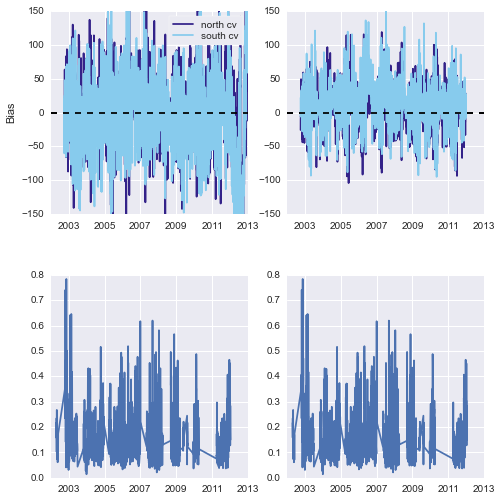

In [100]:
#####################################
## Time series of bias by Grouping ##
#####################################
# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(2,3,width_ratios=[12,12,12],height_ratios=[12,12,12])
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
    ax = plt.subplot(gs[0,n-1])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
    grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    for m,gr in enumerate(grouping):
        plt.plot(grobs_diff.time,grobs_diff.loc[{'Grouping':gr}].mean(dim='Grouping'),color=colsche[m],label=gr)
    
    # Labels and legend
    if n == 1:
        ax.legend(ncol=1,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)   
        ax.set_ylabel('Bias')
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-150,150)
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ax = plt.subplot(gs[1,n-1])
    plt.plot(aod.index.values,aod.values)
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    
os.chdir(dir_print)
fname = 'SWdwn_bias_monthly.groups.png'
fig.savefig(fname)


grobs
syn
Stats for :syn
(-0.08570498662311922, 0.001800360869526791)
mtclim
Stats for :mtclim
(-0.041058250389114592, 0.13538553637147796)


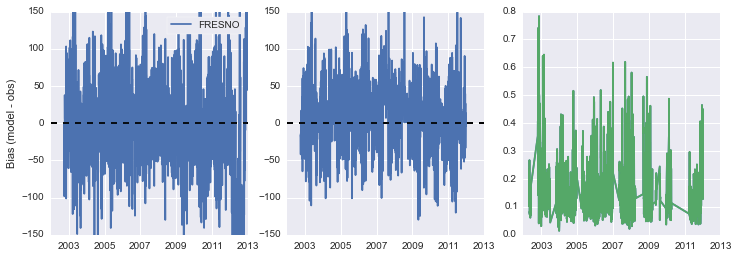

In [117]:
#####################################
## Time series of bias by Grouping ##
#####################################
from scipy.stats.stats import pearsonr

# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_names = ['grobs','syn','mtclim']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)
fig = plt.figure(figsize=(12,12))
gs = matplotlib.gridspec.GridSpec(1,3,width_ratios=[12,12,12],height_ratios=[3,3,3])
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
    ax = plt.subplot(gs[0,n-1])
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
#     for m,gr in enumerate(grouping):
    plt.plot(grobs_diff.time,grobs_diff.loc[{'station':'FRESNO'}].values,label='FRESNO')
    
    # Labels and legend
    if n == 1:
        ax.legend(ncol=1,labelspacing=.25,markerscale=2,numpoints=1,columnspacing=.3,frameon=True)   
        ax.set_ylabel('Bias (model - obs)')
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    ax.set_ylim(-150,150)
    plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')

    ax = plt.subplot(gs[0,2])
    plt.plot(aod.index.values,aod.values)
    ax.set_xlim(datetime(2002,1,1),datetime(2013,1,1))
    
    print('Stats for :'+pr)
    d1 = datetime(2004,1,1)
    d2 = datetime(2011,1,1)
    obs = grobs_diff.loc[{'station':'FRESNO'}]
    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
#     print(obs)
#     a = aod.loc[d1:d2]
#     print(obs.values.shape)
#     print(a)
    print(pearsonr(obs.values[np.where(~np.isnan(obs.aod.values))],obs.aod.values[np.where(~np.isnan(obs.aod.values))]))

grobs
syn
mtclim
grobs
syn
mtclim


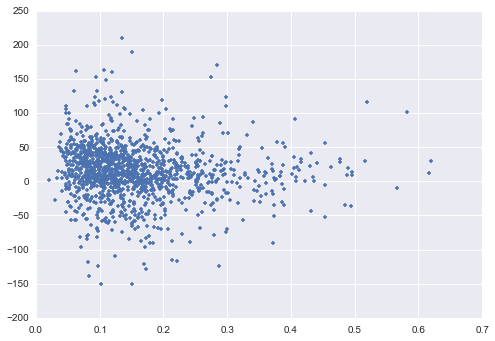

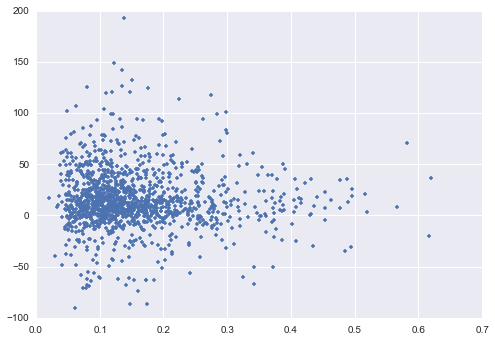

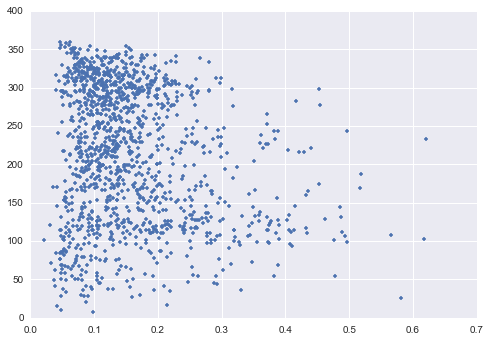

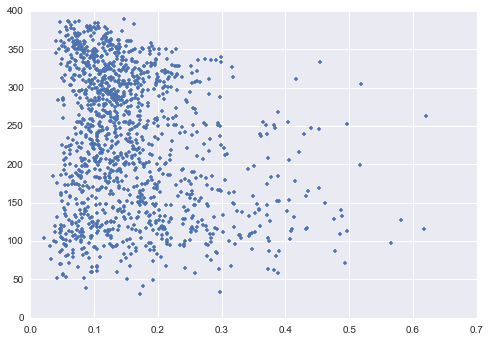

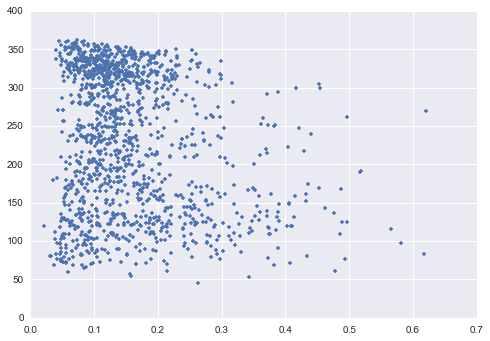

In [7]:
#####################################
## Time series of bias by Grouping ##
#####################################
from scipy.stats.stats import pearsonr
import solargeo

# formating preface
# grouping = ['north cv','south cv','west of crest','foothills','east of crest']
pr_names = ['grobs','syn','mtclim']
grouping = ['north cv','south cv']
colsche =   np.array([[51.,34.,138.],\
            [136.,204.,238.],\
            [17.,119.,71.],\
            [221.,204.,119.],\
            [204.,102.,119.]])
colsche = np.divide(colsche,256.)

# Dates
d1 = datetime(2004,1,1)
d2 = datetime(2010,9,1)
# Elevation angle
# el = solargeo.AVG_EL(grobs.loc[{'station':'FRESNO'}].time.values,\
#                      grobs.loc[{'station':'FRESNO'}].latitude.values,\
#                      grobs.loc[{'station':'FRESNO'}].longitude.values,\
#                      -8,'END')
for n,pr in enumerate(pr_names):
    print(pr)
    
    if pr == 'grobs':
        continue
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
    grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    obs = grobs_diff.loc[{'station':'FRESNO'}]
    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')
    
    
for n,pr in enumerate(pr_names):
    print(pr)
    
#     ax = plt.subplot(gs[0,n-1])
#     plt.plot(np.array([datetime(2002,1,1),datetime(2013,1,1)]),np.array([0,0]),'k--')
#     grobs_diff = (grobs[pr]-grobs.SWdwn)
#     grobs_diff = grobs_diff.swap_dims({'station':'Grouping'})
    
    # Buid dataset
    if pr == 'grobs':
        obs = grobs.SWdwn.loc[{'station':'FRESNO'}]
    else:
        obs = grobs[pr].loc[{'station':'FRESNO'}]

    a = aod.reindex(obs.time.values,fill_value=np.nan)
    obs['aod'] = (['time'],a)
    obs = obs.loc[d1:d2]
    plt.figure()
    plt.plot(obs.aod.values,obs.values,'.',label='FRESNO')   
 

In [15]:
import solargeo
reload(solargeo)
d1 = datetime(2004,1,2)
d2 = datetime(2004,2,1)
# Elevation angle
pd_time = pd.to_datetime(grobs.time.loc[d1:d2].values)
pd_dt = pd_time[1]-pd_time[0]

el = solargeo.AVG_EL(pd.to_datetime(grobs.time.loc[d1:d2].values),\
                     grobs.loc[{'station':'FRESNO'}].latitude.values,\
                     grobs.loc[{'station':'FRESNO'}].longitude.values,\
                     0,'END')
plt.plot(el)
# plt.plot(np.arcsin(grobs.SWdwn.values/1365))

ZeroDivisionError: integer division or modulo by zero